In [266]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from  sklearn.model_selection import TimeSeriesSplit

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm

from arch import arch_model 

from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

from warnings import filterwarnings
filterwarnings("ignore")

# PROJECT-6. Time series analysis and predictions

## Part 1

### Загрузка данных

In [267]:
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=['year'], index_col='year')
data

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


На всякий случай проверяем на пропуски

In [268]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 1960-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GDP (current US$)  62 non-null     float64
dtypes: float64(1)
memory usage: 992.0 bytes


Явных пропусков нет, однако есть 0ое значение (с ним мы поработаем во второй части):

In [269]:
data[data['GDP (current US$)'] < 1000000]

,GDP (current US$)
year,
1961-01-01,0.0


### Исходный временной ряд

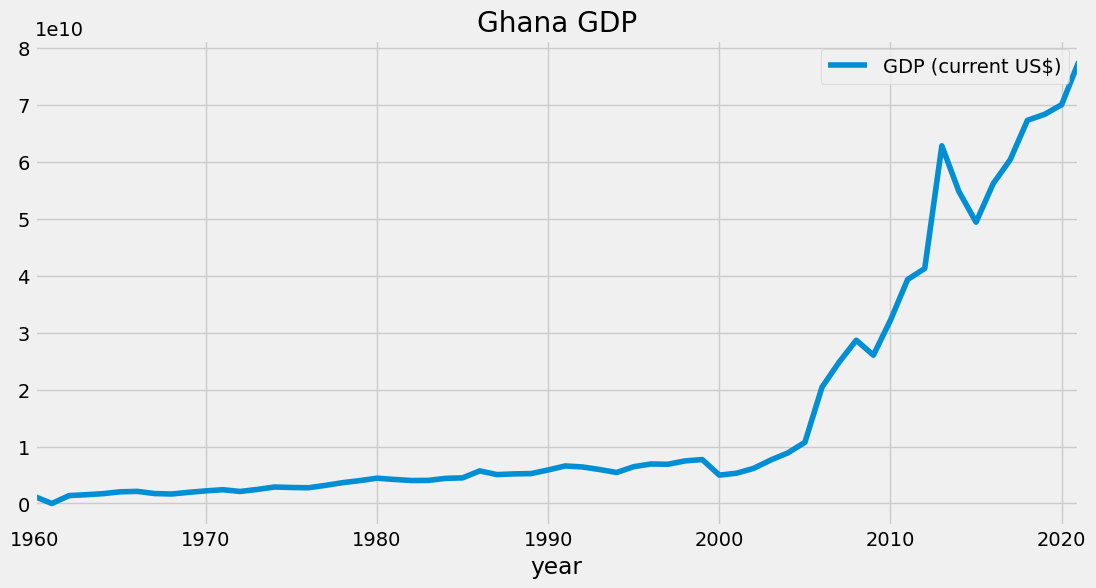

In [270]:
plt.rcParams["figure.figsize"] = 12, 6
fig = data.plot()
plt.title('Ghana GDP')
plt.show()

Разложим временной ряд

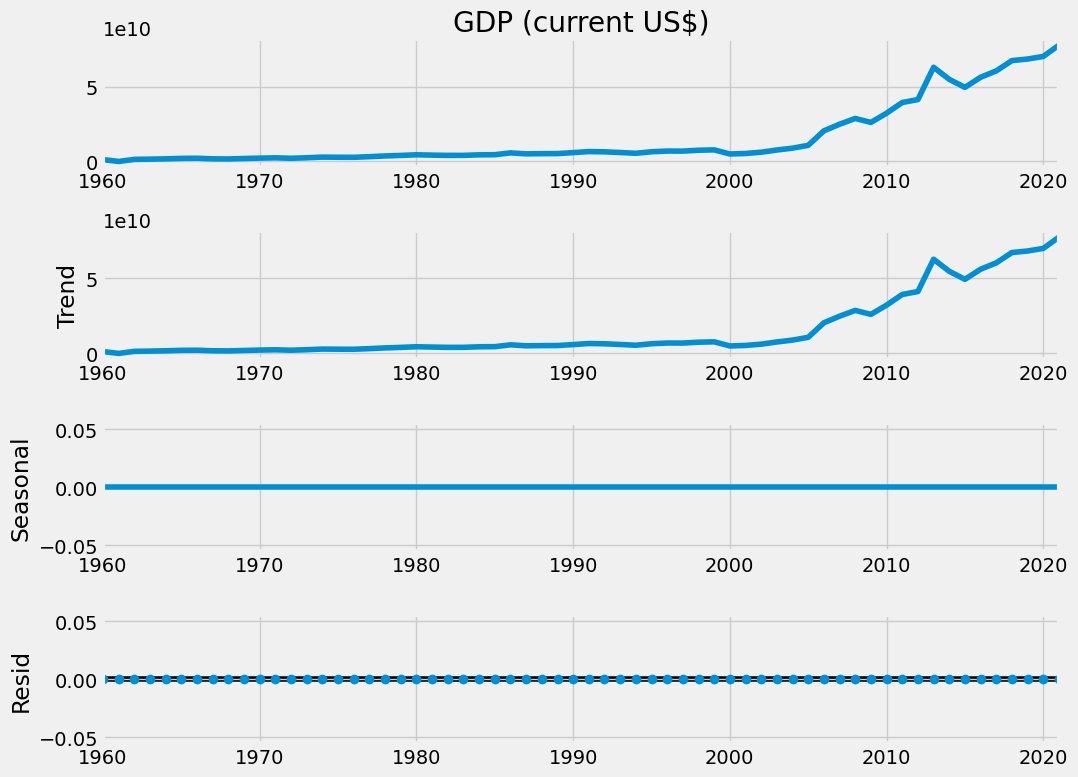

In [271]:
plt.rcParams["figure.figsize"] = 11, 8
result = seasonal_decompose(data['GDP (current US$)'])
result.plot()
plt.show()

По графикам видим, что:
-  компонента тренда состоит из двух отрезков, медленный практически линейный рост до начала 2000х, после видим более быстрый рост (общий тенденция линейное увеличение, но с некторыми 'скачками' - резкими отклонениями, например как в 2013);
- сезонность и цикличность отсутсвует;
- шум отсутствует.

### Разбиение выборки

Отложим последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [272]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

## График скользящего среднего

Построим несколько графиков с разным размером окна.

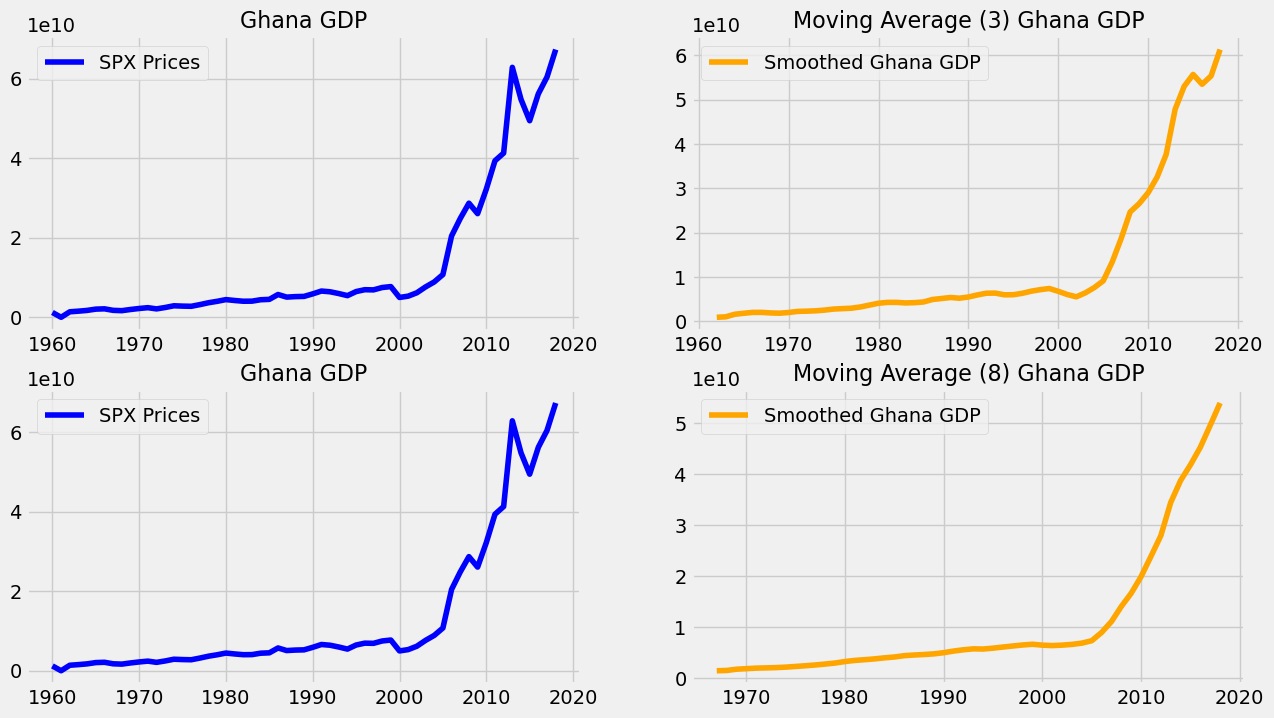

In [273]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
# Окно в 3 года (Window = 3)
ax[0, 0].plot(train_df['GDP (current US$)'], color="blue", label="SPX Prices")
ax[0, 0].set_title("Ghana GDP", size=16)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df['GDP (current US$)'].rolling(window=3).mean(),
    color="orange",
    label="Smoothed Ghana GDP",
)

ax[0, 1].set_title("Moving Average (3) Ghana GDP", size=16)
ax[0, 1].legend()


# Окно в 8 лет - (2 презеденских срока в ганне) (Window = 8)
ax[1, 0].plot(train_df['GDP (current US$)'], color="blue", label="SPX Prices")
ax[1, 0].set_title("Ghana GDP", size=16)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df['GDP (current US$)'].rolling(window=8).mean(),
    color="orange",
    label="Smoothed Ghana GDP",
)

ax[1, 1].set_title("Moving Average (8) Ghana GDP", size=16)
ax[1, 1].legend()

plt.show()


Построены 2 графика:
-  с окном 3 года - позволяет сгладить  мелкие выбросы и отклонения от тренда, однако оставляет информацию о больших выбросах в данных - в нашем случае эти выбросы это участи резкого спада или роста экономики - достаточно важная информация (например с 2012 года в Ганне было сильное замедление роста ВВП и рост инфляции и гос. долга);
-  с окном в 8 лет - теряем часть информации о локальных кризисах или периодах резкого роста экономики, зато получаем чистый тренд ВВП состоящий из 2х линейных отрезков: до 2005 и после (о чем мы и говорили ранее).

### Проврка ряда на стационарность.

Проверку произведем с помощью теста Дики-Фуллера

In [274]:
test1 = adfuller(train_df['GDP (current US$)'])
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885355
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Ряд не стационарен, сезонности нет - будем использовать модель ARIMA, для ее использования найдем параметр d - количество дифференцирований, необходимых для сведения ряда к стационарному.

In [275]:
d = 0
series = train_df['GDP (current US$)']
for i in range(1,5):
    print(f'd={i}', f'{"":.^40}')
    series = series.diff().dropna()
    test1 = adfuller(series)
    print("adf:", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("ряд нестационарен")
    else:
        print("ряд стационарен")
        print(f'количество диффер. = {i}')
        d = i
        break

d=1 ........................................
adf: -1.6702483038320772
p-value:  0.4465029329713892
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен
d=2 ........................................
adf: -2.6408690561284858
p-value:  0.08484116917837747
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен
d=3 ........................................
adf: -4.779623784828528
p-value:  5.9483276402250296e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен
количество диффер. = 3


### Построим коррелограммы ACF и PACF для нахождения параметров p и q

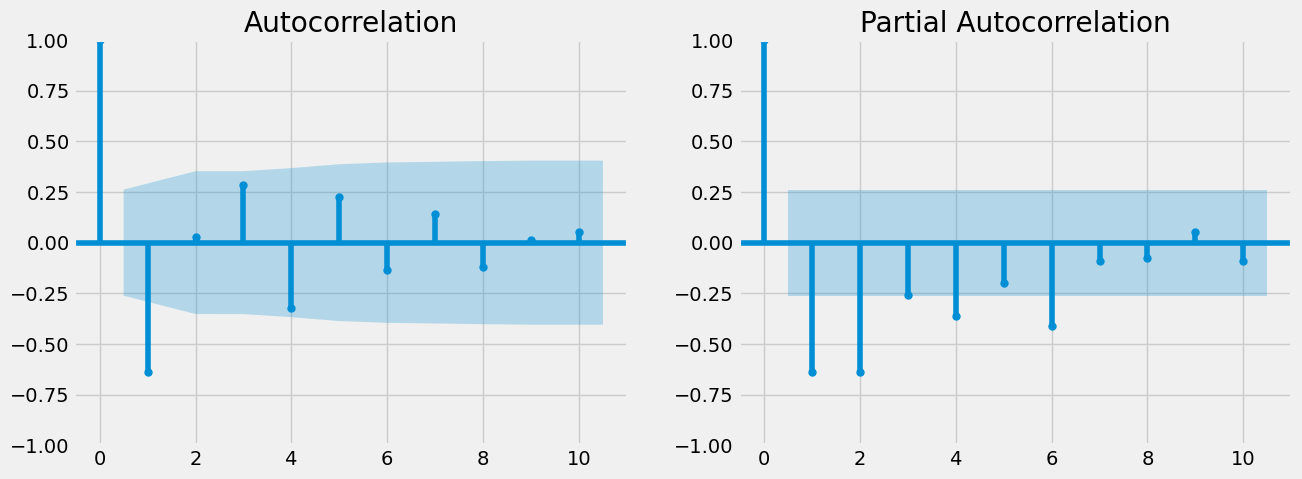

In [276]:
def plot_acf_pacf(series):
    fig, axes = plt.subplots(1, 2, figsize=(14,5))
    sgt.plot_acf(series, ax=axes[0], lags=10)
    sgt.plot_pacf(series, ax=axes[1], lags=10, method="ywm")
    plt.show()
    
plot_acf_pacf(series)

По построенным коррелограммам ACF и PACF интегрированного ряда 3го порядка, p = 2 (по PACF), q = 1 (по ACF)

### Построение модели ARIMA p = 2, d=3, q = 1

In [277]:
arima_model = ARIMA(train_df['GDP (current US$)'], order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sat, 23 Sep 2023   AIC                           2659.231
Time:                        14:36:59   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Модель показала результат AIC = 2659.231, попробуем теперь подберать наилучшие параметры с помощью пакета **pmdarima**.

In [278]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=4,
    max_q=4,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.02 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.02 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.02 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.335 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Sat, 23 Sep 2023   AIC                           2659.231
Time:                        14:36:59   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

Подобранные параметры с помощью pmdarima полностью совпали с найдеными нами ранее ручным методом - ARIMA(2,3,1).

### Выполним предсказание для отложенной тестовой выборки 

In [279]:
pred_df = pd.DataFrame(index=data.index)
pred_df["model_preds"] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['GDP (current US$)'] = data['GDP (current US$)']
forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%
pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

In [280]:
pred_df

,model_preds,GDP (current US$),model_preds_lower,model_preds_upper
year,,,,
1960-01-01,NaN,1.217087e+09,NaN,NaN
1961-01-01,NaN,0.000000e+00,NaN,NaN
1962-01-01,NaN,1.382353e+09,NaN,NaN
1963-01-01,NaN,1.540616e+09,NaN,NaN
1964-01-01,NaN,1.731092e+09,NaN,NaN
...,...,...,...,...
2017-01-01,NaN,6.040638e+10,NaN,NaN
2018-01-01,NaN,6.729928e+10,NaN,NaN
2019-01-01,7.368591e+10,6.833754e+10,6.269386e+10,8.467796e+10


### Графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза

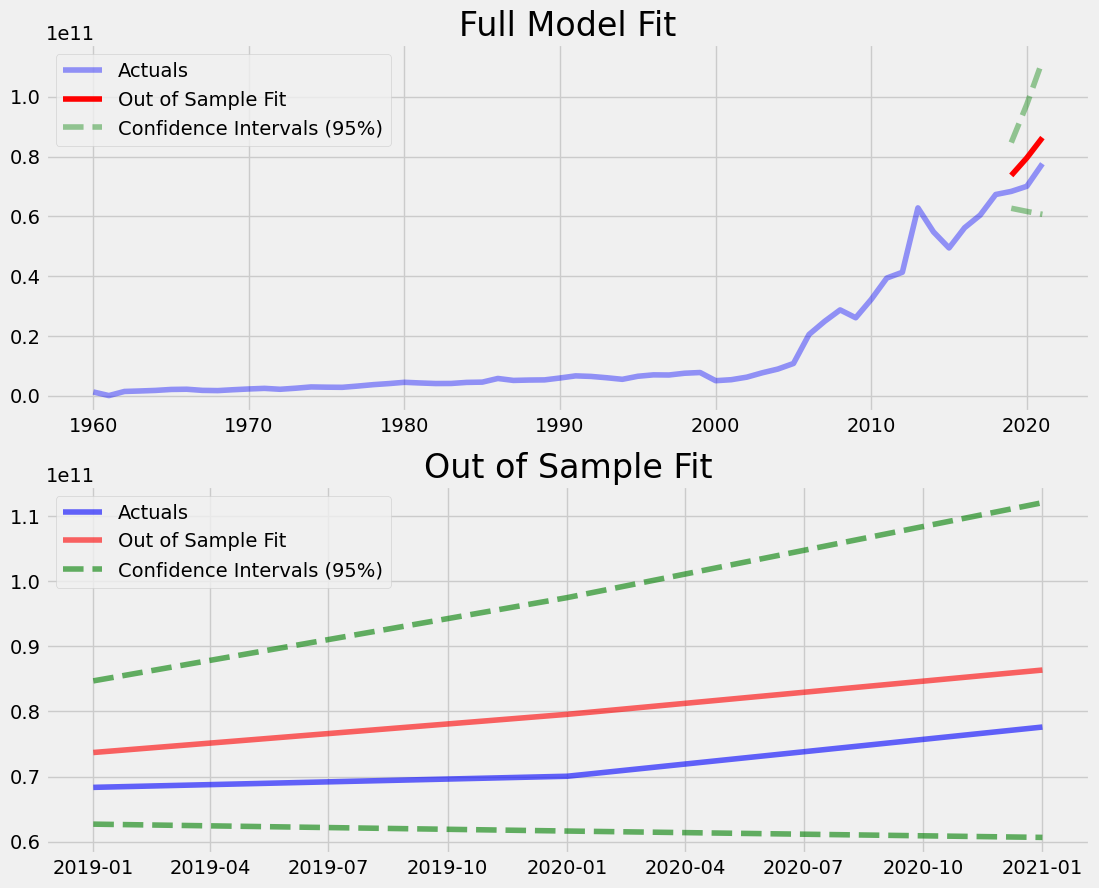

In [281]:
def plot_predict(pred_df, test_df):
    plt.rcParams["figure.figsize"] = 12, 10

    plt.subplot(2, 1, 1)
    plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

    plt.plot(
        pred_df.loc[test_df.index]["model_preds"],
        color="red",
        linestyle="-",
        label="Out of Sample Fit",
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_lower"],
        color="green",
        linestyle="--",
        label="Confidence Intervals (95%)",
        alpha=0.4,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_upper"],
        color="green",
        linestyle="--",
        alpha=0.4,
    )

    plt.title("Full Model Fit", size=24)
    plt.legend()

    plt.subplot(2, 2, (3,4))

    plt.plot(
        pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds"],
        color="red",
        linestyle="-",
        label="Out of Sample Fit",
        alpha=0.6,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_lower"],
        color="green",
        linestyle="--",
        label="Confidence Intervals (95%)",
        alpha=0.6,
    )

    plt.plot(
        pred_df.loc[test_df.index]["model_preds_upper"],
        color="green",
        linestyle="--",
        alpha=0.6,
    )

    plt.title("Out of Sample Fit", size=24)
    plt.legend()

    plt.show()
    
plot_predict(pred_df, test_df)

In [282]:
print(f"MAPE={mean_absolute_percentage_error(test_df, pred_df.loc[test_df.index]['model_preds'])*100:.3f}%")

MAPE=10.888%


По полученным результам построения модели видно, что:
- наша модель уловила тренд (причем тренд активного роста который виден с начала 2000х),
- MAPE 10 процентов, что говорит о неплохой точности прогроза модели, по крайней мере на короткий срок в 3 интервала.
- реальное значения ВВП лежит в предсказанном 95%-ом доверительном интервале.

Из вышесказанного, можно сделать вывод, что модель построена достаточно успешно, одако стоит поработать с нашим 0ым значением (Хотя на первый взгляд, врятли 0 значение в самом начале временного ряда сможет сильно повлиять на прогноз).


## Part 2

Как мы уже проверили в самом начале явных пропусков (nan)  у нас нет, однако есть пропуски в данных, которые заполнены нулями. Преобразуем их в nan.

In [283]:
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
data = data.asfreq(freq='AS')
data.isna().sum()

GDP (current US$)    1
dtype: int64

Заполним пропуск с помощью интерполяции.

In [284]:
data['GDP (current US$)'].interpolate(method='linear', inplace=True)

Снова разделим выборку

In [285]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

### Проверка на стационарность

In [286]:
d = 0
series = train_df['GDP (current US$)']
for i in range(0,5):
    print(f'd={i}', f'{"":.^40}')
    test1 = adfuller(series)
    print("adf:", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("ряд нестационарен")
        series = series.diff().dropna()
    else:
        print("ряд стационарен")
        print(f'количество диффер. = {i}')
        d = i
        break

d=0 ........................................
adf: 0.8030073326980104
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен
d=1 ........................................
adf: -1.8255652246435998
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен
d=2 ........................................
adf: -2.634634746007845
p-value:  0.08604813722197624
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен
d=3 ........................................
adf: -4.825603687304036
p-value:  4.857318076799624e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен
количество диффер. = 3


Все также имеем интегрированный ряда 3го порядка, d=3, однако стоит отметить, что значение статистики на всех шагах интегрирования чуть уменьшилось как и p-value, это показывает, что согласно тесту ряд был ближе к стационарному чем до интерполяции.

### Подбор параметров модели

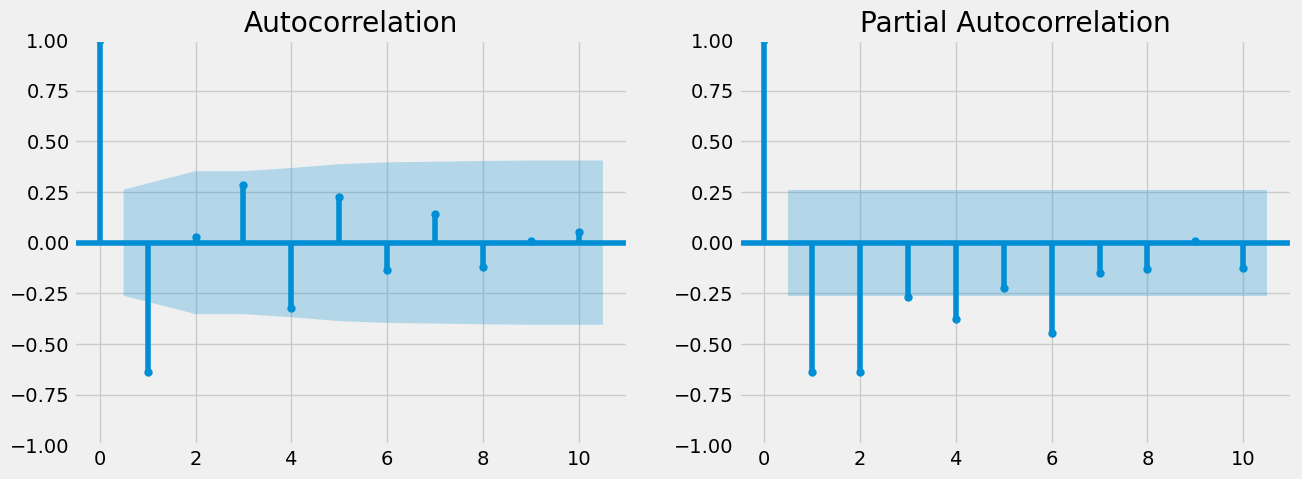

In [287]:
plot_acf_pacf(series)

По построенным коррелограммам ACF и PACF интегрированного ряда 3го порядка, параметры не изменились, p = 2 (по PACF), q = 1 (по ACF)

### Моделирование

In [288]:
arima_model = ARIMA(train_df['GDP (current US$)'], order=(2, 3, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sat, 23 Sep 2023   AIC                           2659.226
Time:                        14:37:00   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+56. Standard errors may be unstable.
"""

На всякий случай проверим подбор параметров с помощью pmdarima

In [289]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=4,
    max_q=4,
    seasonal=False,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.02 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.03 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.02 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.297 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Sat, 23 Sep 2023   AIC                           2659.226
Time:                        14:37:01   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+56. Standard errors may be unstable.
"""

Оптимальные параметры модели совпали с найдеными в ручную. 

Получим прогноз

In [290]:
pred_df = pd.DataFrame(index=data.index)
pred_df["model_preds"] = arima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])
pred_df['GDP (current US$)'] = data['GDP (current US$)']
forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%
pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

Визуализируем

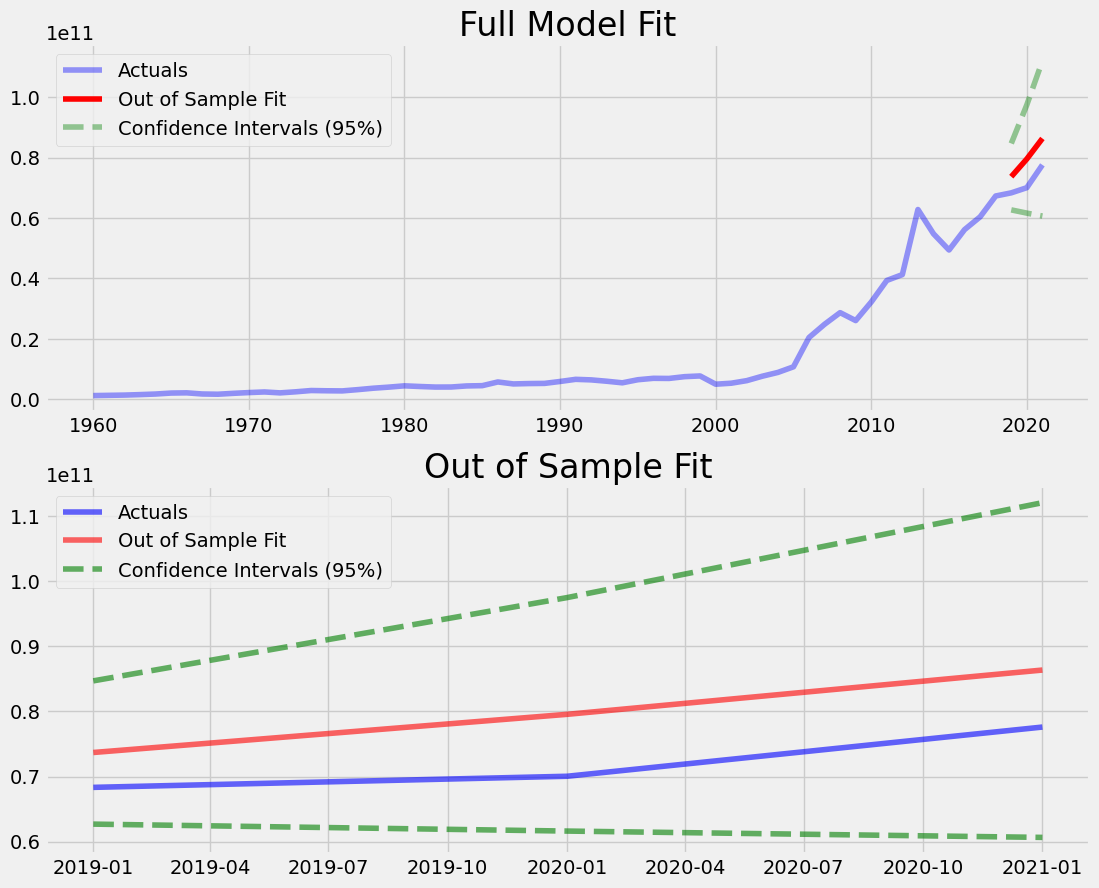

In [291]:
plot_predict(pred_df, test_df)

In [292]:
print(f"MAPE={mean_absolute_percentage_error(test_df, pred_df.loc[test_df.index]['model_preds'])*100:.3f}%")

MAPE=10.893%


В результате,
-  до интерполяции AIC оптимизированной модели был равен 2659.231, после интерполяции - AIC=2659.226,
- до интерполяции MAPE=10.888%, после MAPE=10.893%.

С одной стороны ожидаемо мы получили, что результат стал лучше на совсем незначимиые тысячные доли процента, однако с учетом, что у нас было пропущено всего одно значение в самом начале ряда, можно сказать, что интерполяция большего числа пропущенных значений, может сильно улучшить качество моделей, причем как на самом этапе построения, так и сыграть решающую роль при определения порядка интегрирования ряда, если до интерполяции у нас была пограничная ситуация. 

## Part 3 Волатильность 

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [293]:
data['GDP (current US$)_vol'] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
data["GDP (current US$)_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Freq: AS-JAN, Name: GDP (current US$)_vol, dtype: float64

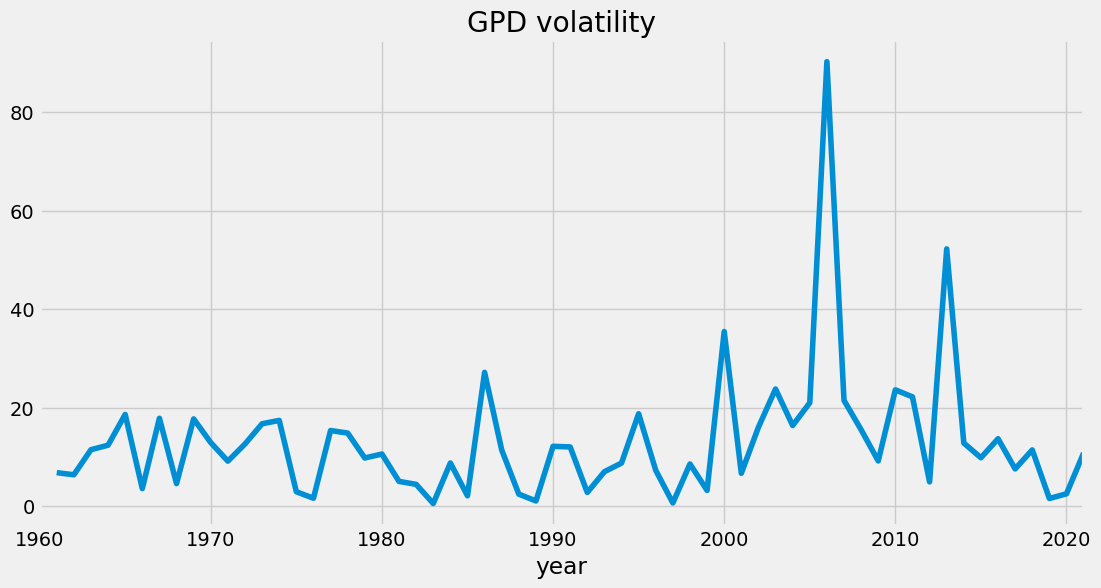

In [294]:
plt.rcParams['figure.figsize'] = 12,6
data['GDP (current US$)_vol'].plot()
plt.title('GPD volatility')
plt.show()

Видим, что волатильность изменяется примерно в одном диапазоне до начала 2000х, после это резкий скачок  в районе 2005-6, и еще один пик в 2013, после чего ее находятся снова в небольшом диапазоне.

Видим, что волатильность меняется со временем, ARIMA не умеет учитывать такие изменения, чтобы улучшить качество нашего прогноза и учитывать дополнительно изменения дисперсии в предсказаниях, попробуем построить дополнительно GARCH-модель.

In [295]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 2), (3, 2))

Проверим ряд волатилильности на стационарность.

In [296]:
d = 0
series = train_df['GDP (current US$)_vol'].dropna()
for i in range(0,5):
    print(f'd={i}', f'{"":.^40}')
    test1 = adfuller(series)
    print("adf:", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("ряд нестационарен")
        series = series.diff().dropna()
    else:
        print("ряд стационарен")
        print(f'количество диффер. = {i}')
        d = i
        break

d=0 ........................................
adf: -6.725311059553777
p-value:  3.4014596148856737e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен
количество диффер. = 0


Исходный ряд волотильности стационарен. Построим коррелограммы

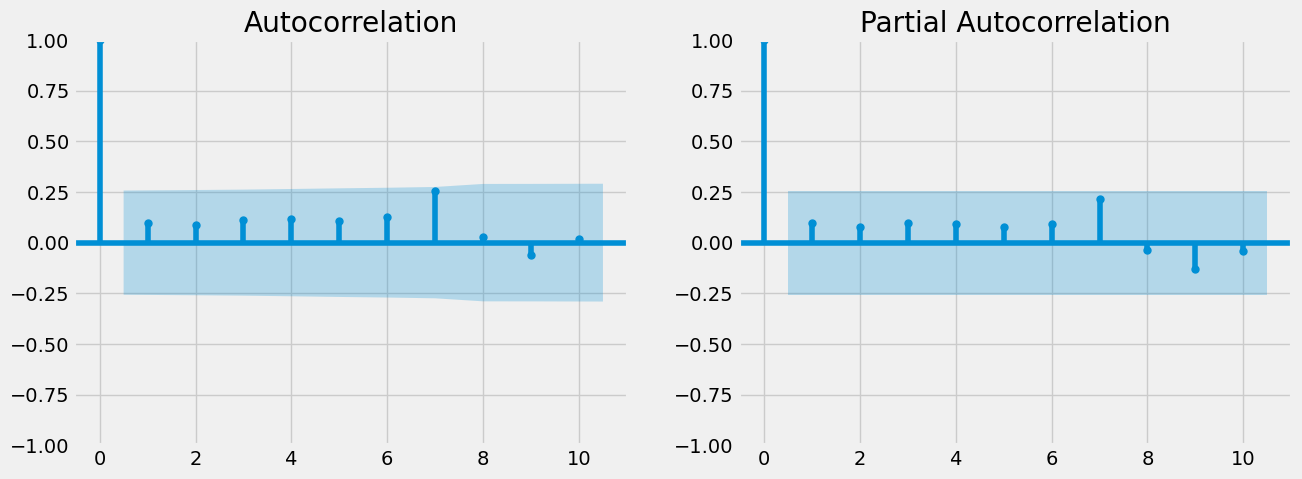

In [297]:
plot_acf_pacf(series)

Возьмем сначала p,q = 1

In [298]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data["GDP (current US$)_vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если применить к нашей обучающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "GDP (current US$)_vol"] = train_df["GDP (current US$)_vol"].dropna()

In [299]:
model = arch_model(garch_df["GDP (current US$)_vol"].dropna(), p=1, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0])

Iteration:      1,   Func. Count:      6,   Neg. LLF: 241.9755861825515
Iteration:      2,   Func. Count:     12,   Neg. LLF: 230.57551668535086
Iteration:      3,   Func. Count:     17,   Neg. LLF: 230.5253911783457
Iteration:      4,   Func. Count:     22,   Neg. LLF: 230.153813350104
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:      6,   Func. Count:     33,   Neg. LLF: 250.88223730003082
Iteration:      7,   Func. Count:     39,   Neg. LLF: 247.3848318221798
Iteration:      8,   Func. Count:     45,   Neg. LLF: 240.38840967935226
Iteration:      9,   Func. Count:     51,   Neg. LLF: 241.23867960370163
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     11,   Func. Count:     65,   Neg. LLF: 236.90954513471712
Iteration:     12,   Func. Count:     71,   Neg. LLF: 234.87183210880022
Iteration:     13,   Func. Count:     77,   Neg. LLF: 230.92958507527516
Iteration:     14,   Func. Count:     83,   Neg. LLF: 22

In [300]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     GDP (current US$)_vol   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -226.598
Distribution:                     Normal   AIC:                           461.196
Method:               Maximum Likelihood   BIC:                           469.437
                                           No. Observations:                   58
Date:                   Sat, Sep 23 2023   Df Residuals:                       57
Time:                           14:37:02   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

А теперь, с помощью подбора, найдем оптимальные параметры для Garch

In [301]:
best_aic = np.inf
best_order = None
best_model = None

for i in range(5):
    for j in range(5):
        try:
            # Создание и обучение модели GARCH с заданными параметрами и остатками ARIMA модели в качестве входных данных
            model = arch_model(garch_df["GDP (current US$)_vol"].dropna(), p=i, q=j)
            model_fit = model.fit(last_obs=test_df.index[0], disp="off")
            # Получение значения AIC для модели
            aic = model_fit.aic
            # Сохранение лучшей модели, порядка и AIC
            if aic < best_aic:
                best_aic = aic
                best_order = (i,j)
                best_model = model_fit
        except:
            continue

print("Best GARCH model:", best_order, "AIC:", best_aic)

Best GARCH model: (3, 0) AIC: 448.95121338010676


In [302]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = best_model.forecast().residual_variance.loc[
    test_df.index
]

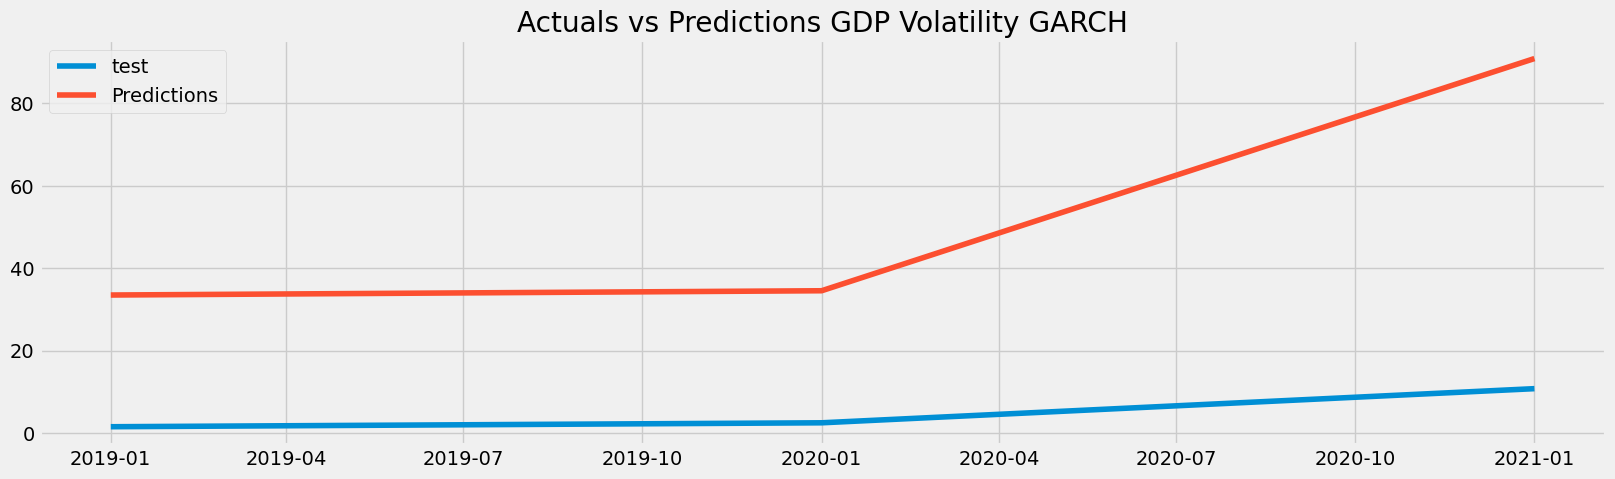

In [303]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP (current US$)_vol"].abs(), label='test')
plt.plot(predictions_df["Predictions"], label='Predictions')

plt.title("Actuals vs Predictions GDP Volatility GARCH")
plt.legend()
plt.show()

MSE:

In [304]:
mean_squared_error(
    predictions_df['GDP (current US$)_vol'].abs(), predictions_df["Predictions"]
)

2821.596273894734

Судя по полученным результатам, модель плохо уловила дисперсию (хотя и прослеживается, что общий тренд изменения она уловила - в 2020 году видим точку увеличения скорости роста волотильности, но с масштабом значений все очень печально), так как такое поведение было для неё новым, прямо перед тестовой выборкой, на трейне, идут большие скачки волотильности, а на тестовой волотильность резко стабилизируется и изменяется в небольшом диапазоне, такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке ранее, поэтому модель выдала предсказания сильно больше, чем они есть на самом деле, также имеем достаточно мало данных в тестовой части, чтобы корректно оценить качество.

Сравним результаты GARCH с ,например, линейной регресиией.

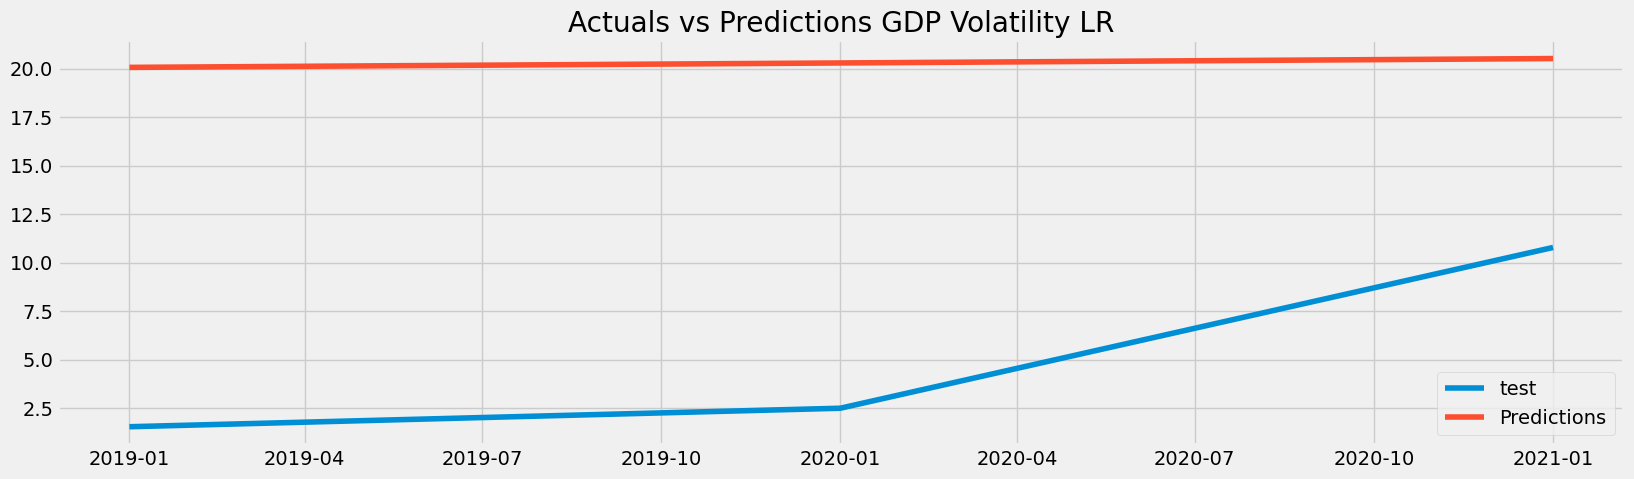

In [305]:
X_train = pd.DataFrame(range(data["GDP (current US$)_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["GDP (current US$)_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP (current US$)_vol"].fillna(0)
y_test = test_df["GDP (current US$)_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test, label='test')
plt.plot(pd.Series(lr_predict, index=y_test.index), label='Predictions')
plt.legend()
plt.title("Actuals vs Predictions GDP Volatility LR")
plt.show()

In [306]:
mean_squared_error(
    y_test, lr_predict
)

251.4089377647131

Из-за описанной выше особенности нашего набора данных и точки его деления на трейн и тест, (где я описал почему модель GARCH показала себя слабо), модель линейной регрессии, хоть и по своей структуре не сможет хорошо предсказать изменения на каждом шаге, но благодаря своему "сглаживающему" характеру, маленькому Variance, и в данном случае сильно меньшему смещению по сравнению с GARCH (Линейная регрессия не сильно подстроилась под большие скачки на конце трейна, поэтому выдала лучший результат на тесте, где эти скачки пропали) показала себя лучше.

---

 попробуем реализовать валидацию на множественном разбиение для LR и GARCH

In [307]:
tscv = TimeSeriesSplit(n_splits=7, test_size=3)
mse_lr = []
train_test_groups = tscv.split(data['GDP (current US$)']) 
for train_index, test_index in train_test_groups:
    # print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
    X_train = pd.DataFrame(range(data["GDP (current US$)_vol"].shape[0]))[
    : len(train_index)].fillna(0)
    X_test = pd.DataFrame(range(data["GDP (current US$)_vol"].shape[0]))[
    len(train_index) : len(train_index)+3].fillna(0)
    y_train = data.iloc[train_index, 1].fillna(0)
    y_test = data.iloc[test_index , 1].fillna(0)

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_predict = lr.predict(X_test)
        
    mse_lr.append(mean_squared_error(y_test, lr_predict))
    
print(f'MSE {np.mean(mse_lr):-^70}')
    

MSE --------------------------440.18544972773685--------------------------


In [308]:
tscv = TimeSeriesSplit(n_splits=7, test_size=3)
mse_GARCH = []
train_test_groups = tscv.split(data['GDP (current US$)']) 
for train_index, test_index in train_test_groups:


    garch_df = pd.DataFrame(data["GDP (current US$)_vol"].loc[data.index])
    garch_df.loc[data.iloc[train_index].index, "GDP (current US$)_vol"] = data.iloc[train_index]["GDP (current US$)_vol"].dropna()
    
    # Сдесь уже лучше всего показывют себя параметры GARCH(3,1)
    model = arch_model(garch_df["GDP (current US$)_vol"].dropna(), p=3, q=1)

    model_results = model.fit(last_obs=data.iloc[train_index].index[-1], disp=False)
    predictions_df = data.iloc[test_index].copy()
    predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
        data.iloc[test_index].index
    ]
    print(predictions_df["Predictions"])
    mse_GARCH.append(mean_squared_error(
        predictions_df['GDP (current US$)_vol'].abs(), predictions_df["Predictions"]
    ))
            
    
    
print(f'MSE {np.mean(mse_GARCH):-^70}')

year
2001-01-01    39.323962
2002-01-01    43.826281
2003-01-01    41.411677
Freq: AS-JAN, Name: Predictions, dtype: float64
year
2004-01-01    76.541235
2005-01-01    77.414722
2006-01-01    78.288210
Freq: AS-JAN, Name: Predictions, dtype: float64
year
2007-01-01    82.969466
2008-01-01    83.902159
2009-01-01    84.834853
Freq: AS-JAN, Name: Predictions, dtype: float64
year
2010-01-01     69.905763
2011-01-01     32.701215
2012-01-01    233.260166
Freq: AS-JAN, Name: Predictions, dtype: float64
year
2013-01-01    273.655135
2014-01-01    277.530575
2015-01-01    281.406016
Freq: AS-JAN, Name: Predictions, dtype: float64
year
2016-01-01    46.603274
2017-01-01    34.781018
2018-01-01    53.470583
Freq: AS-JAN, Name: Predictions, dtype: float64
year
2019-01-01    295.569078
2020-01-01    299.354244
2021-01-01    303.139410
Freq: AS-JAN, Name: Predictions, dtype: float64
MSE --------------------------25438.30731451656---------------------------


На аналоге кросс-валидации, имеем 7 разбиений, которые заканчиваются в разные характеры поведения временного ряда волотильности, до резкого роста, во время и после. Линейная регрессия, хоть показала среднюю метрику по 7ми разбиениях хуже чем на 1 последнем, все еще показывает себя сильно лучше GARCH модели, которая показала себя почти в 10 раз хуже чем на 1 разбиении, еще раз убеждаемся, что если модель встречает такое поведение, которое было для неё новым и подобные случаи отсутствовали в обучающей выборке, это приводит к очень плохим результатам.

---
дополнительно

### NEURALPROPHET

Попробуем построить предсказания с помощью NEURALPROPHET

In [309]:
from neuralprophet import NeuralProphet

In [310]:
train = pd.DataFrame(columns=['ds', 'y'])
train['y'] = train_df['GDP (current US$)']
train['ds'] = train_df.index

In [311]:
nprophet_model = NeuralProphet()
metrics = nprophet_model.fit(train, freq="AS")
future_df = nprophet_model.make_future_dataframe(train, 
                                                 periods = 3, 
                                                 n_historic_predictions=len(train))
preds_df_2 = nprophet_model.predict(future_df)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.305% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - AS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 768
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (4) is too small than the required number for the learning rate finder (205). The r

Finding best initial lr:   0%|          | 0/205 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.305% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - AS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.387% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - AS
INFO - (NP.df_utils._infer_frequency) - Major frequency YS corresponds to 98.387% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - AS


Predicting: 4it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [312]:
preds_df_2.index = data.index
preds_df_2

,ds,y,yhat1,trend,season_yearly
year,,,,,
1960-01-01,1960-01-01,1.217087e+09,8.165718e+08,4.944550e+10,-4.862893e+10
1961-01-01,1961-01-01,1.299720e+09,1.840467e+09,4.955294e+10,-4.771247e+10
1962-01-01,1962-01-01,1.382353e+09,1.627668e+09,4.966009e+10,-4.803242e+10
1963-01-01,1963-01-01,1.540616e+09,1.429332e+09,4.976724e+10,-4.833790e+10
1964-01-01,1964-01-01,1.731092e+09,1.245454e+09,4.987438e+10,-4.862893e+10
...,...,...,...,...,...
2017-01-01,2017-01-01,6.040638e+10,6.339180e+10,1.111043e+11,-4.771247e+10
2018-01-01,2018-01-01,6.729928e+10,6.705077e+10,1.150832e+11,-4.803242e+10
2019-01-01,2019-01-01,NaN,7.072419e+10,1.190621e+11,-4.833790e+10


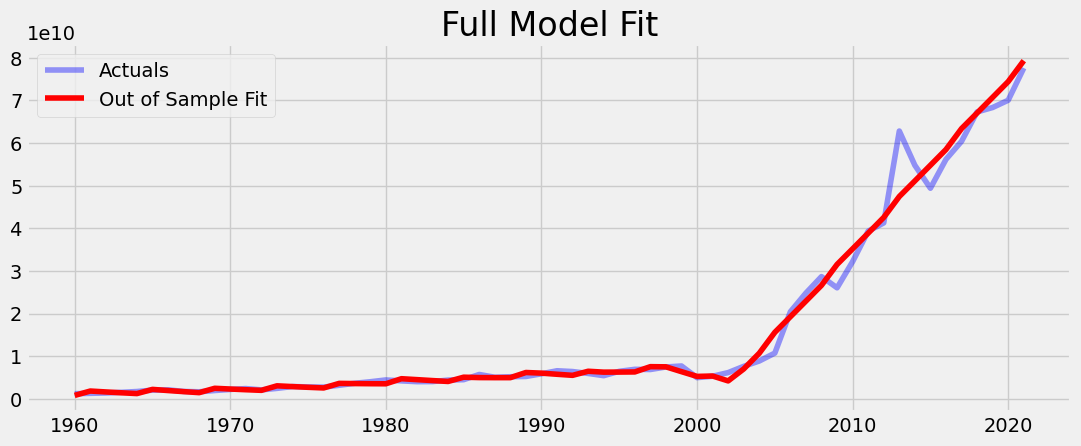

In [313]:
pred_df = preds_df_2
plt.rcParams["figure.figsize"] = 12, 10

plt.subplot(2, 1, 1)
plt.plot(data['GDP (current US$)'], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df["yhat1"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)



plt.title("Full Model Fit", size=24)
plt.legend()


plt.legend()

plt.show()


In [314]:
print(f"MAPE={mean_absolute_percentage_error(test_df['GDP (current US$)'], pred_df.loc[test_df.index]['yhat1'])*100:.3f}%")

MAPE=3.984%


Модель NEURALPROPHET показала себя наилучшим образом, по метрики MAPE результат получился в 3 раз лучше, чем у ARIMA, отлично уловила тренд и его изменения.